In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import category_encoders as ce
from sklearn.metrics import r2_score
from datetime import datetime # для работы с временными переменными
import warnings
import spacy # для работы с текстом
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
import string
from gensim.models.fasttext import FastText
from gensim.matutils import unitvec

In [2]:
# снять ограничение на кол-во показываемых колонок
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
df_issues_train = pd.read_csv("train_issues.csv")
df_comment_train = pd.read_csv("train_comments.csv")

df_issues_test = pd.read_csv("test_issues.csv")
df_comment_test = pd.read_csv("test_comments.csv")

df_emp = pd.read_csv("employees.csv")

sample_solution = pd.read_csv('sample_solution.csv', index_col='id')

# Сформируем датасет

In [4]:
def join_text(df_comment):
    temp_df_comment_train = pd.DataFrame(columns = ['text', 'id'])
    for idx in df_comment['issue_id'].unique():
        text = '\n'.join(df_comment[df_comment['issue_id'] == idx]['text']) # тексты относящиеся к одному случаю
        row = [text, idx] # создаём строчку
        temp_df_comment_train.loc[len(temp_df_comment_train)] = row # вставляем в temp объединённый текст
    return temp_df_comment_train

df_comment_train = join_text(df_comment_train)
df_comment_test = join_text(df_comment_test)

# джойним датасеты комментариев и запросов
df_issues_train = df_issues_train.merge(df_comment_train, left_on='id', right_on='id', how='left')
df_issues_test = df_issues_test.merge(df_comment_test, left_on='id', right_on='id', how='left')

In [5]:
# функция добавляет суффикс к данным о работнике чтобы можно было отличить assignee от creator
def rename_cols(df, sfx):
    temp_df = df.copy()
    cols = df.columns[1:] # не берём id(первая колонка)
    for col in cols:
        temp_df = temp_df.rename(columns={col: col+sfx})
    return temp_df

# джойним датасеты запросов и работников
train = df_issues_train.merge(rename_cols(df_emp, '_assignee'), left_on='assignee_id', right_on='id', how='left', suffixes = ('', '_assignee_del')).drop(['id_assignee_del','key'],1)
train = train.merge(rename_cols(df_emp, '_creator'), left_on='creator_id', right_on='id', how='left', suffixes = ('', '_creator_del')).drop(['id_creator_del'],1)

test = df_issues_test.merge(rename_cols(df_emp, '_assignee'), left_on='assignee_id', right_on='id', how='left', suffixes = ('', '_assignee_del')).drop(['id_assignee_del','key'],1)
test = test.merge(rename_cols(df_emp, '_creator'), left_on='creator_id', right_on='id', how='left', suffixes = ('', '_creator_del')).drop(['id_creator_del'],1)

In [6]:
# объединю колонки с текстом
train['text'] = train['summary'] + ' ' + train['text']
test['text'] = test['summary'] + ' ' + test['text']

train = train.drop(['summary'], 1)
test = test.drop(['summary'], 1)

In [7]:
train.head(4)

,id,created,project_id,assignee_id,creator_id,overall_worklogs,text,active_assignee,full_name_assignee,position_assignee,hiring_type_assignee,payment_type_assignee,salary_calculation_type_assignee,english_level_assignee,passport_assignee,is_nda_signed_assignee,is_labor_contract_signed_assignee,is_added_to_internal_chats_assignee,is_added_one_to_one_assignee,active_creator,full_name_creator,position_creator,hiring_type_creator,payment_type_creator,salary_calculation_type_creator,english_level_creator,passport_creator,is_nda_signed_creator,is_labor_contract_signed_creator,is_added_to_internal_chats_creator,is_added_one_to_one_creator
0,819952,2019-10-01 05:57:18.000,5,93,93,1800,NaN,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
1,819949,2019-10-01 05:59:45.000,5,93,93,7200,"UI тесты раздела ""Профиль"" Приверила и приняла...",1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
2,819947,2019-10-01 06:00:38.000,5,93,93,14400,NaN,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1
3,819943,2019-10-01 06:02:49.000,5,93,93,900,NaN,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1,1,Olga Bush,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


# Обработка данных

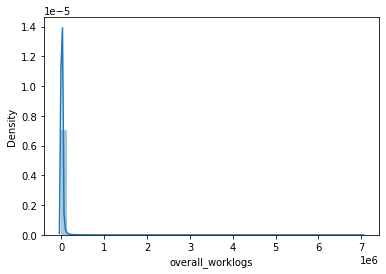

<AxesSubplot:xlabel='overall_worklogs', ylabel='Density'>

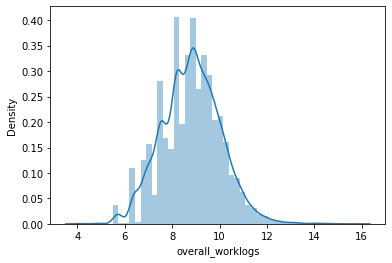

In [8]:
sns.distplot(train['overall_worklogs'])
plt.show()
sns.distplot(np.log(train['overall_worklogs']))

In [9]:
# train['overall_worklogs'] = np.log(train['overall_worklogs'])

После логарифмирование распределение стало нормальным

# id

In [10]:
print(len( set(train['id'].values.tolist()) & set(test['id'].values.tolist()) ) / len(set( train['id'].values.tolist() + test['id'].values.tolist() )))

0.0


In [11]:
# совпадений нет => удалим колонку
train = train.drop('id',1)
test = test.drop('id',1)

# assignee_id, creator_id

In [12]:
# переменная содержащая инфу о том является ли создатель и исполнитель одним и тем же человеком
def is_equal(vals):
    if vals[0] == vals[1]:
        return 1
    return 0

train['assignee_is_creator'] = list(map(is_equal, train[['assignee_id', 'creator_id']].values))
test['assignee_is_creator'] = list(map(is_equal, test[['assignee_id', 'creator_id']].values))

# full_name_assignee

In [13]:
train = train.drop(['full_name_assignee', 'full_name_creator'],1)
test = test.drop(['full_name_assignee', 'full_name_creator'],1)

# created

In [14]:
# time featuring
train['created'] = pd.to_datetime(train['created'].map(lambda x: x[:-4]), format = "%Y-%m-%d %H:%M:%S")
test['created'] = pd.to_datetime(test['created'].map(lambda x: x[:-4]), format = "%Y-%m-%d %H:%M:%S")

train['created_month'] = pd.DatetimeIndex(train['created']).month
train['created_day'] = pd.DatetimeIndex(train['created']).day
train['created_day_of_week'] = pd.DatetimeIndex(train['created']).day_of_week
train['created_hour'] = pd.DatetimeIndex(train['created']).hour
train['created_minute'] = pd.DatetimeIndex(train['created']).minute
train['created_second'] = pd.DatetimeIndex(train['created']).second

test['created_month'] = pd.DatetimeIndex(test['created']).month
test['created_day'] = pd.DatetimeIndex(test['created']).day
test['created_day_of_week'] = pd.DatetimeIndex(test['created']).day_of_week
test['created_hour'] = pd.DatetimeIndex(test['created']).hour
test['created_minute'] = pd.DatetimeIndex(test['created']).minute
test['created_second'] = pd.DatetimeIndex(test['created']).second

train = train.drop(['created'],1)
test = test.drop(['created'],1)

# active_assignee, active_creator

In [15]:
train['active_assignee'].value_counts()

1    8185
0    1404
Name: active_assignee, dtype: int64

# hiring_type_assignee, hiring_type_creator

In [16]:
train['hiring_type_assignee'].value_counts()

staff        7005
non_staff     625
Name: hiring_type_assignee, dtype: int64

In [17]:
bin_cols = ['hiring_type_assignee', 'hiring_type_creator']
for col in bin_cols:
    enc = LabelEncoder()
    enc.fit(train[col].values.reshape(-1,1))
    train[col] = enc.transform(train[col].values.reshape(-1,1))
    test[col] = enc.transform(test[col].values.reshape(-1,1))

<AxesSubplot:xlabel='hiring_type_assignee', ylabel='overall_worklogs'>

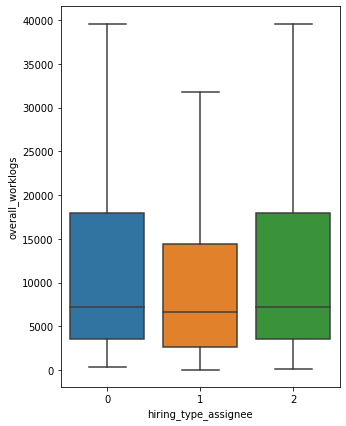

In [18]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'hiring_type_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# payment_type_assignee, payment_type_creator

In [19]:
train['payment_type_assignee'].value_counts()

fixed     5765
hourly    1764
Name: payment_type_assignee, dtype: int64

In [20]:
bin_cols = ['payment_type_assignee', 'payment_type_creator']
for col in bin_cols:
    enc = LabelEncoder()
    enc.fit(train[col].values.reshape(-1,1))
    train[col] = enc.transform(train[col].values.reshape(-1,1))
    test[col] = enc.transform(test[col].values.reshape(-1,1))

<AxesSubplot:xlabel='payment_type_assignee', ylabel='overall_worklogs'>

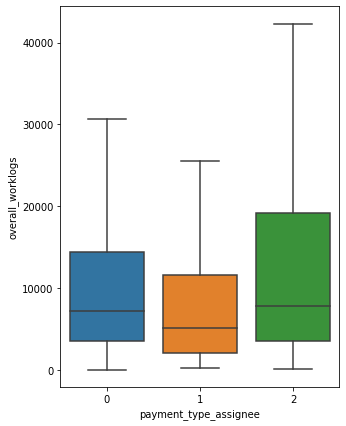

In [21]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'payment_type_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# salary_calculation_type_assignee, salary_calculation_type_creator

In [22]:
train['salary_calculation_type_assignee'].value_counts()

net      137
gross     76
Name: salary_calculation_type_assignee, dtype: int64

In [23]:
train['salary_calculation_type_assignee'] = train['salary_calculation_type_assignee'].notna().astype(int)
train['salary_calculation_type_creator'] = train['salary_calculation_type_creator'].notna().astype(int)
test['salary_calculation_type_assignee'] = test['salary_calculation_type_assignee'].notna().astype(int)
test['salary_calculation_type_creator'] = test['salary_calculation_type_creator'].notna().astype(int)

<AxesSubplot:xlabel='salary_calculation_type_assignee', ylabel='overall_worklogs'>

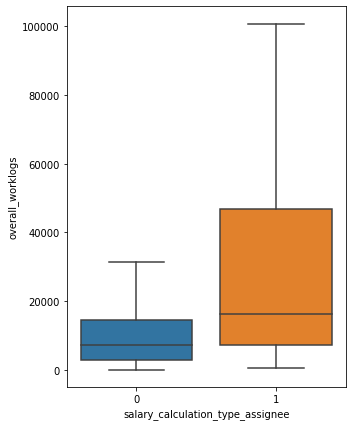

In [24]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'salary_calculation_type_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# english_level_assignee

In [25]:
train['english_level_assignee'].value_counts()

B1    358
C1    176
Name: english_level_assignee, dtype: int64

In [26]:
train['english_level_assignee'] = train['english_level_assignee'].notna().astype(int)
train['english_level_creator'] = train['english_level_creator'].notna().astype(int)
test['english_level_assignee'] = test['english_level_assignee'].notna().astype(int)
test['english_level_creator'] = test['english_level_creator'].notna().astype(int)

<AxesSubplot:xlabel='english_level_creator', ylabel='overall_worklogs'>

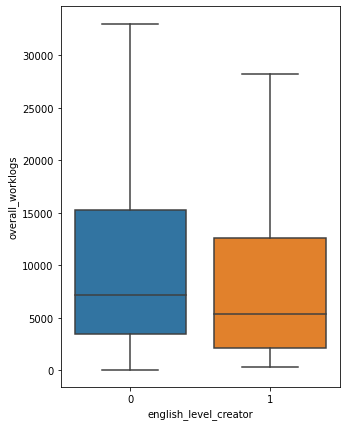

In [27]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'english_level_creator', y = 'overall_worklogs', data = train, showfliers = False)

# passport_assignee

In [28]:
train['passport_assignee'].value_counts()

1    6688
0    2901
Name: passport_assignee, dtype: int64

<AxesSubplot:xlabel='passport_assignee', ylabel='overall_worklogs'>

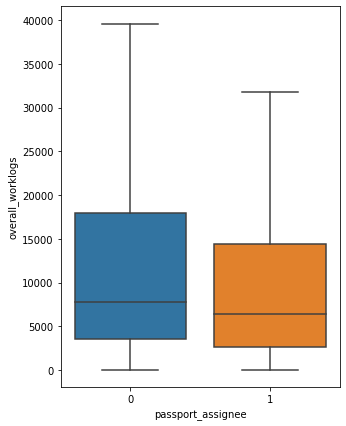

In [29]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'passport_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# is_nda_signed_assignee

In [30]:
train['is_nda_signed_assignee'].value_counts()

1    6688
0    2901
Name: is_nda_signed_assignee, dtype: int64

<AxesSubplot:xlabel='is_nda_signed_assignee', ylabel='overall_worklogs'>

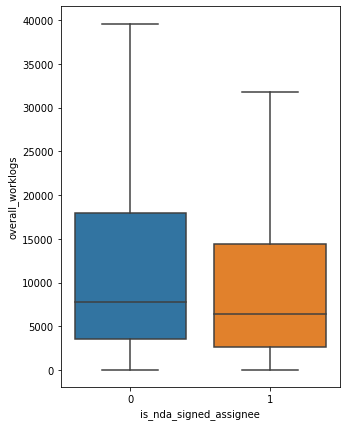

In [31]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'is_nda_signed_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# is_labor_contract_signed_assignee

In [32]:
train['is_labor_contract_signed_assignee'].value_counts()

1    6339
0    3250
Name: is_labor_contract_signed_assignee, dtype: int64

<AxesSubplot:xlabel='is_labor_contract_signed_assignee', ylabel='overall_worklogs'>

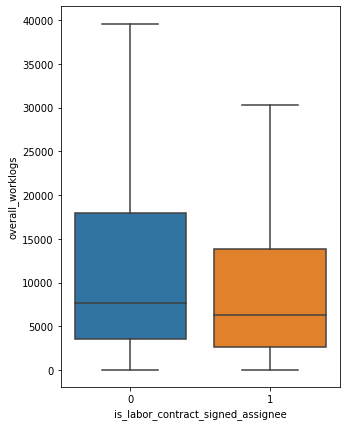

In [33]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'is_labor_contract_signed_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# is_added_to_internal_chats_assignee

In [34]:
train['is_added_to_internal_chats_assignee'].value_counts()

1    6688
0    2901
Name: is_added_to_internal_chats_assignee, dtype: int64

<AxesSubplot:xlabel='is_added_to_internal_chats_assignee', ylabel='overall_worklogs'>

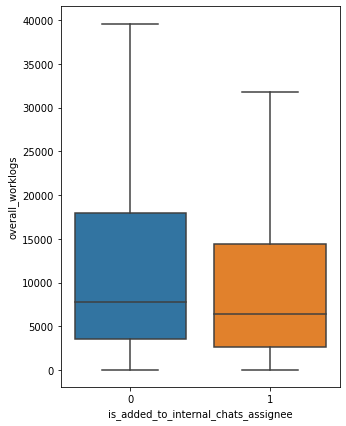

In [35]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'is_added_to_internal_chats_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# is_added_one_to_one_assignee

In [36]:
train['is_added_one_to_one_assignee'].value_counts()

1    6251
0    3338
Name: is_added_one_to_one_assignee, dtype: int64

<AxesSubplot:xlabel='is_added_one_to_one_assignee', ylabel='overall_worklogs'>

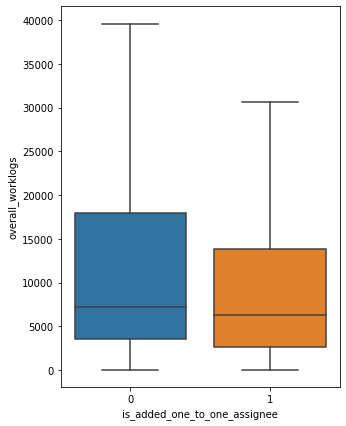

In [37]:
fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(x = 'is_added_one_to_one_assignee', y = 'overall_worklogs', data = train, showfliers = False)

# text

In [38]:
# проверим есть ли в 
def has_cyrillic(text):
    return int(bool(re.search('[а-яА-Я]', text)))

train['text'] = train['text'].fillna('')
test['text'] = test['text'].fillna('')

train['text_is_ru'] = train['text'].map(lambda x: has_cyrillic(x))
test['text_is_ru'] = test['text'].map(lambda x: has_cyrillic(x))

In [39]:
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

In [40]:
train['text'] = train['text'].map(lambda x: clean_text(x))
test['text'] = test['text'].map(lambda x: clean_text(x))

In [41]:
nlp_en = spacy.load("en_core_web_sm")
nlp_ru = spacy.load("ru_core_news_sm")

In [42]:
def to_doc(x):
    if x[1]:
        return nlp_ru(x[0])
    return nlp_en(x[0])

train['text'] = list(map(to_doc, train[['text', 'text_is_ru']].values))
test['text'] = list(map(to_doc, test[['text', 'text_is_ru']].values))

In [43]:
# лемматизация
train['text'] = train['text'].map(lambda x: [i.lemma_ for i in x])
test['text'] = test['text'].map(lambda x: [i.lemma_ for i in x])

In [44]:
# стоп-слова удалить после токенизации и лемматизации
stop_words = stopwords.words('russian') + stopwords.words('english')

train['text'] = train['text'].map(lambda x: [word for word in x if word not in stop_words])
test['text'] = test['text'].map(lambda x: [word for word in x if word not in stop_words])

In [45]:
# удалим самые частовстречающиеся слова
words = Counter(train['text'].sum())
most_common_words = words.most_common(36)
train['text'] = train['text'].map(lambda x: [word for word in x if word not in most_common_words])
test['text'] = test['text'].map(lambda x: [word for word in x if word not in most_common_words])

In [46]:
# создадим переменную содержащую количество слов
train['n_words'] = train['text'].map(lambda x: len(x))
test['n_words'] = test['text'].map(lambda x: len(x))

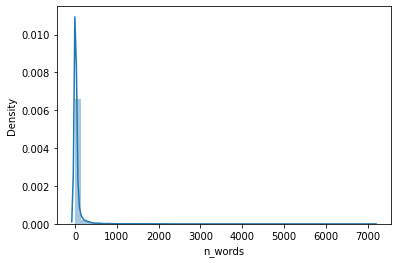

<AxesSubplot:xlabel='n_words', ylabel='Density'>

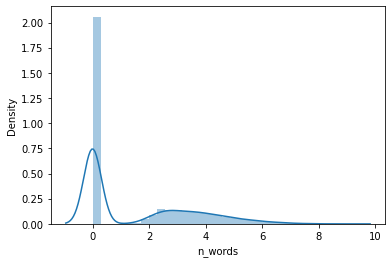

In [47]:
sns.distplot(train['n_words'])
plt.show()
sns.distplot(np.log(train['n_words']+1))

Можно попробовать отлогарифмировать

In [48]:
# train['n_words'] = np.log(train['n_words']+1)
# test['n_words'] = np.log(test['n_words']+1)

In [49]:
# train['text'] = train['text'].map(lambda x: ' '.join(x))
# test['text'] = test['text'].map(lambda x: ' '.join(x))

In [50]:
vector_size = 47

In [51]:
ft_model = FastText(train['text'], vector_size = vector_size, min_count = 20, \
                    sample = 1e-2, window = 30, epochs = 20)

In [52]:
def fast_encode(x):
    if len(x) == 0:
        return np.zeros(vector_size)
    vec = sum([ft_model.wv[i] for i in x])
    return vec/np.linalg.norm(vec)

In [53]:
train['text'] = train['text'].map(lambda x: fast_encode(x))

In [54]:
test['text'] = test['text'].map(lambda x: fast_encode(x))

In [55]:
train[[f'text_{i}' for i in range(vector_size)]] = np.concatenate(train['text']).reshape( -1, vector_size)

In [56]:
test[[f'text_{i}' for i in range(vector_size)]] = np.concatenate(test['text']).reshape( -1, vector_size)

In [57]:
train = train.drop('text',1)
test = test.drop('text',1)

In [58]:
train.head(5)

,project_id,assignee_id,creator_id,overall_worklogs,active_assignee,position_assignee,hiring_type_assignee,payment_type_assignee,salary_calculation_type_assignee,english_level_assignee,passport_assignee,is_nda_signed_assignee,is_labor_contract_signed_assignee,is_added_to_internal_chats_assignee,is_added_one_to_one_assignee,active_creator,position_creator,hiring_type_creator,payment_type_creator,salary_calculation_type_creator,english_level_creator,passport_creator,is_nda_signed_creator,is_labor_contract_signed_creator,is_added_to_internal_chats_creator,is_added_one_to_one_creator,assignee_is_creator,created_month,created_day,created_day_of_week,created_hour,created_minute,created_second,text_is_ru,n_words,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46
0,5,93,93,1800,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,10,1,1,5,57,18,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,93,93,7200,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,10,1,1,5,59,45,1,7,0.100368,-0.190363,0.164037,-0.062685,0.106981,-0.192244,0.122612,0.148767,-0.086349,0.068895,-0.166799,-0.041896,0.291660,0.215522,0.313685,-0.015796,0.102549,-0.104436,0.047153,-0.141069,-0.134522,0.037970,0.098938,0.004371,0.091041,-0.144988,-0.160199,0.034142,0.109431,-0.064752,-0.156588,-0.229613,-0.200376,0.000454,0.060048,0.039908,-0.005654,0.414219,0.099300,0.152495,0.027894,-0.072341,0.063625,0.228488,0.086089,0.070955,0.134579
2,5,93,93,14400,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,10,1,1,6,0,38,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,93,93,900,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,10,1,1,6,2,49,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,93,93,900,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,Разработчик мобильных приложений,1,0,0,0,1,1,1,1,1,1,10,1,1,6,3,26,1,8,0.107681,-0.142712,0.148269,-0.071494,0.126463,-0.159455,0.183393,0.104836,-0.114673,0.072807,-0.143526,-0.060334,0.270274,0.192069,0.303251,-0.023940,0.121207,-0.107592,0.038758,-0.132079,-0.072328,0.064271,0.103047,0.048792,0.098171,-0.149920,-0.153086,0.028524,0.084512,-0.071600,-0.166021,-0.263258,-0.227926,-0.014730,0.087886,0.053320,-0.008359,0.447918,0.073222,0.155079,0.003135,-0.086589,0.015903,0.222785,0.061103,0.085129,0.124267


# Последующее кодирование будет задействовать целевую переменную => разделим на валидацию и трейн

In [59]:
X_train = train.drop('overall_worklogs', 1)
Y_train = train['overall_worklogs']
X_test = test
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=228)

# project_id

In [60]:
print(len( set(train['project_id'].values.tolist()) & set(test['project_id'].values.tolist()) ) / len(set( train['project_id'].values.tolist() + test['project_id'].values.tolist() )))

1.0


In [61]:
# полное совпадение значений

# целевое кодирование
categorial_vars = 'project_id'
encoder = ce.CatBoostEncoder()
encoder.fit(X_train[categorial_vars], Y_train)

X_train[categorial_vars] = encoder.transform(X_train[categorial_vars])
X_val[categorial_vars] = encoder.transform(X_val[categorial_vars])
X_test[categorial_vars] = encoder.transform(X_test[categorial_vars])

# assignee_id, creator_id

In [62]:
print(len( set(train['assignee_id'].values.tolist()) & set(test['assignee_id'].values.tolist()) ) / len(set( train['assignee_id'].values.tolist() + test['assignee_id'].values.tolist() )), \
     len( set(train['creator_id'].values.tolist()) & set(test['creator_id'].values.tolist()) ) / len(set( train['creator_id'].values.tolist() + test['creator_id'].values.tolist() )))

0.46296296296296297 0.49056603773584906


In [63]:
# значительное совпадение значений

# целевое кодирование
categorial_vars = ['assignee_id', 'creator_id']
encoder = ce.CatBoostEncoder()
encoder.fit(X_train[categorial_vars], Y_train)

X_train[categorial_vars] = encoder.transform(X_train[categorial_vars])
X_val[categorial_vars] = encoder.transform(X_val[categorial_vars])
X_test[categorial_vars] = encoder.transform(X_test[categorial_vars])

# position_assignee, position_creator

In [64]:
train['position_assignee'].value_counts()

Web-разработчик                             6434
Разработчик мобильных приложений             305
Системный администратор (DevOps инженер)     250
Менеджер проектов                            168
Директор по IT                                87
Web дизайнер                                  71
DevOps инженер                                29
Инженер тестировщик (QA engineer)              7
Delivery Manager                               2
Директор по стратегическому развитию           1
Name: position_assignee, dtype: int64

In [65]:
# целевое кодирование

categorial_vars = ['position_assignee', 'position_creator']
encoder = ce.CatBoostEncoder()
encoder.fit(X_train[categorial_vars], Y_train)

X_train[categorial_vars] = encoder.transform(X_train[categorial_vars])
X_val[categorial_vars] = encoder.transform(X_val[categorial_vars])
X_test[categorial_vars] = encoder.transform(X_test[categorial_vars])

In [66]:
X_train.head(5)

,project_id,assignee_id,creator_id,active_assignee,position_assignee,hiring_type_assignee,payment_type_assignee,salary_calculation_type_assignee,english_level_assignee,passport_assignee,is_nda_signed_assignee,is_labor_contract_signed_assignee,is_added_to_internal_chats_assignee,is_added_one_to_one_assignee,active_creator,position_creator,hiring_type_creator,payment_type_creator,salary_calculation_type_creator,english_level_creator,passport_creator,is_nda_signed_creator,is_labor_contract_signed_creator,is_added_to_internal_chats_creator,is_added_one_to_one_creator,assignee_is_creator,created_month,created_day,created_day_of_week,created_hour,created_minute,created_second,text_is_ru,n_words,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46
1173,13,68,10,1,13359.283532,1,0,0,0,1,1,1,1,1,1,15340.741806,1,0,0,0,1,1,1,1,1,0,5,3,4,14,1,4,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6772,13,365,365,1,13359.283532,1,1,0,0,1,1,1,1,1,1,15340.741806,1,1,0,0,1,1,1,1,1,1,10,5,0,10,45,29,0,31,-0.225255,-0.003632,-0.045087,0.004093,-0.034249,0.124962,-0.441432,0.317794,-0.181489,0.178940,0.222121,0.000368,-0.031307,-0.308752,-0.006339,-0.005924,-0.132502,0.135721,0.098625,-0.129052,-0.199035,0.238785,0.154427,-0.002643,-0.177726,-0.032103,-0.006877,0.032932,-0.070722,-0.159193,0.040196,0.047633,-0.211812,-0.086458,0.121542,0.031452,-0.032084,-0.071939,-0.078447,-0.036786,0.063835,0.118757,0.038410,-0.033254,0.027535,0.075802,0.252933
4488,13,191,191,1,13359.283532,1,1,0,1,1,1,1,1,1,1,15340.741806,1,1,0,1,1,1,1,1,1,1,5,19,1,9,54,52,0,64,0.098316,-0.016432,-0.014881,-0.094879,-0.000612,-0.090488,-0.461414,0.143783,-0.003142,-0.099330,0.088148,0.128856,-0.079101,-0.052317,-0.037321,-0.113044,0.056240,0.247676,-0.157317,0.383965,0.024860,-0.140612,0.141661,-0.180785,0.167488,0.307971,0.032180,-0.075591,-0.024808,-0.002908,-0.235627,-0.162879,-0.081806,-0.064571,-0.050295,-0.283360,0.062149,-0.064417,-0.005440,0.098585,0.018839,-0.000129,0.010449,0.053227,0.119104,-0.135179,0.110963
4587,13,365,365,1,13359.283532,1,1,0,0,1,1,1,1,1,1,15340.741806,1,1,0,0,1,1,1,1,1,1,5,28,3,13,12,39,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1389,13,68,68,1,13359.283532,1,0,0,0,1,1,1,1,1,1,15340.741806,1,0,0,0,1,1,1,1,1,1,6,26,2,12,56,44,0,13,-0.240950,0.138515,-0.018427,-0.025938,-0.079208,0.039848,-0.178744,0.156950,-0.253427,0.085442,0.020146,-0.016993,-0.037637,-0.059862,0.161764,-0.105392,-0.007128,0.261270,0.114404,-0.098171,-0.068019,0.159763,0.283981,-0.007970,-0.145854,-0.030048,-0.066936,-0.060534,-0.172089,-0.313283,0.036564,0.068874,0.023002,-0.019885,0.159457,-0.291170,-0.163098,-0.060994,-0.278921,0.016911,-0.092222,0.058525,-0.187370,-0.030678,0.056494,0.210844,0.248162


<AxesSubplot:>

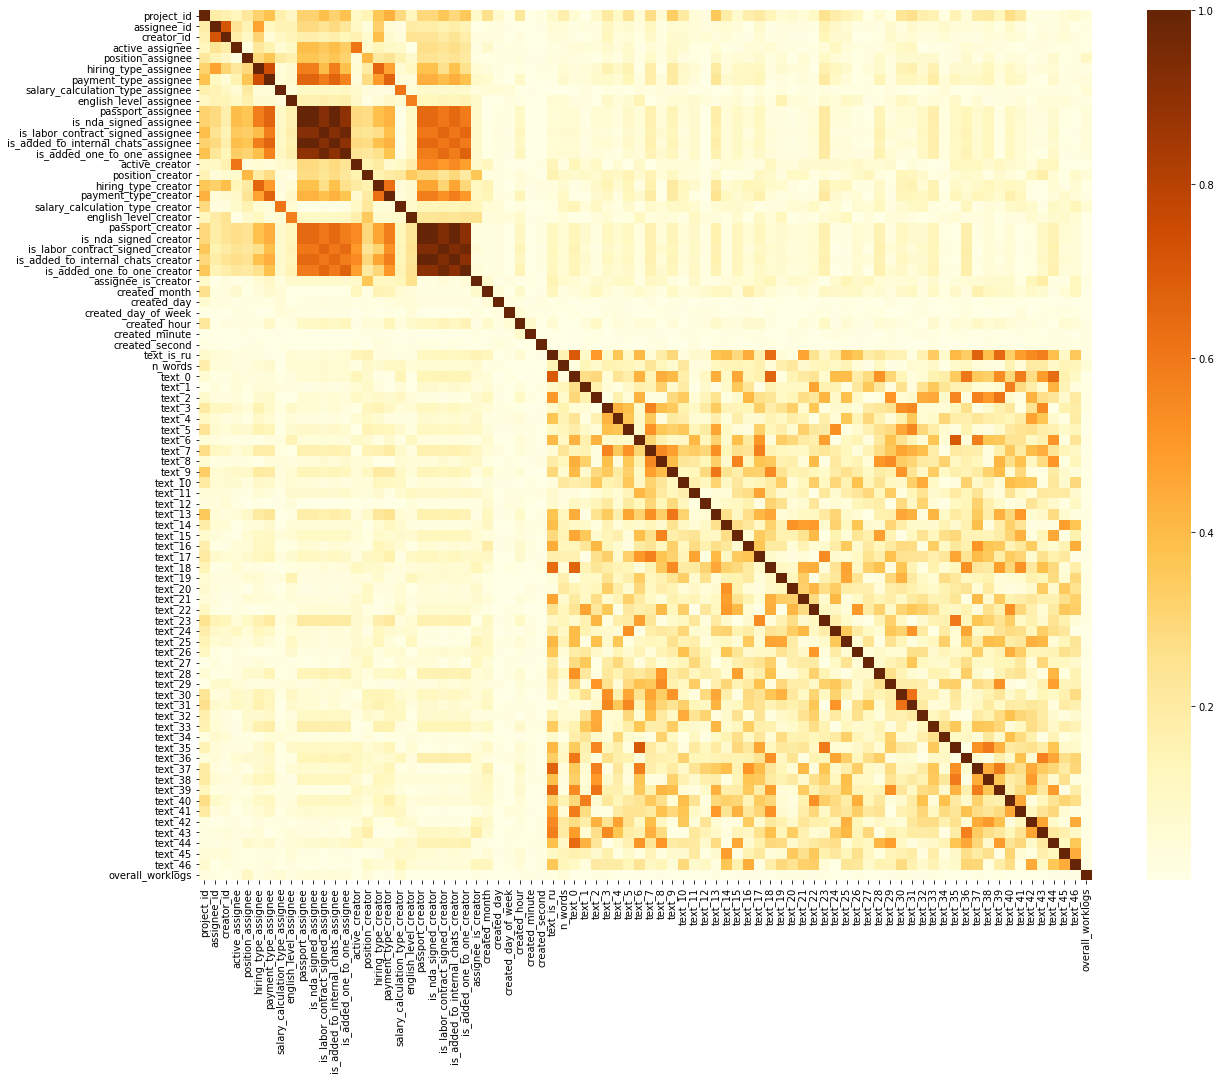

In [67]:
# после всех преобразований взглянем на корреляции
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(pd.concat([X_train, Y_train], axis=1).corr().abs(),ax=ax, cmap = 'YlOrBr', annot = False)

# Создам Temp

In [68]:
X_train_temp = X_train.copy()
X_val_temp = X_val.copy()
X_test_temp = X_test.copy()

In [69]:
cols_to_linear_model = ['hiring_type_assignee', 'payment_type_assignee', 'salary_calculation_type_assignee', \
                        'english_level_assignee', 'passport_assignee', 'is_nda_signed_assignee', \
                        'is_labor_contract_signed_assignee', 'is_added_to_internal_chats_assignee', \
                        'is_added_one_to_one_assignee', 'active_assignee', \
                        'hiring_type_creator', 'payment_type_creator', 'salary_calculation_type_creator', \
                        'english_level_creator', 'passport_creator', 'is_nda_signed_creator', \
                        'is_labor_contract_signed_creator', 'is_added_to_internal_chats_creator', \
                        'is_added_one_to_one_creator', 'active_creator']

In [70]:
svd = TruncatedSVD(n_components=11, n_iter=150)

X_train_temp[[f'svd_{i}' for i in range(svd.n_components)]] = svd.fit_transform(X_train_temp[cols_to_linear_model])
X_val_temp[[f'svd_{i}' for i in range(svd.n_components)]] = svd.transform(X_val_temp[cols_to_linear_model])
X_test_temp[[f'svd_{i}' for i in range(svd.n_components)]] = svd.transform(X_test_temp[cols_to_linear_model])

X_train_temp = X_train_temp.drop(cols_to_linear_model,1)
X_val_temp = X_val_temp.drop(cols_to_linear_model,1)
X_test_temp = X_test_temp.drop(cols_to_linear_model,1)

In [71]:
X_train_temp

,project_id,assignee_id,creator_id,position_assignee,position_creator,assignee_is_creator,created_month,created_day,created_day_of_week,created_hour,created_minute,created_second,text_is_ru,n_words,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10
1173,13,68,10,13359.283532,15340.741806,0,5,3,4,14,1,4,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.610069,-0.931500,0.039967,-0.259313,0.076394,0.099631,-0.019742,-0.014097,-0.113328,-0.033275,0.021566
6772,13,365,365,13359.283532,15340.741806,1,10,5,0,10,45,29,0,31,-0.225255,-0.003632,-0.045087,0.004093,-0.034249,0.124962,-0.441432,0.317794,-0.181489,0.178940,0.222121,0.000368,-0.031307,-0.308752,-0.006339,-0.005924,-0.132502,0.135721,0.098625,-0.129052,-0.199035,0.238785,0.154427,-0.002643,-0.177726,-0.032103,-0.006877,0.032932,-0.070722,-0.159193,0.040196,0.047633,-0.211812,-0.086458,0.121542,0.031452,-0.032084,-0.071939,-0.078447,-0.036786,0.063835,0.118757,0.038410,-0.033254,0.027535,0.075802,0.252933,3.925360,0.056534,0.177405,0.565421,-0.118461,0.123882,-0.398272,-0.187154,-0.092640,0.062762,-0.034075
4488,13,191,191,13359.283532,15340.741806,1,5,19,1,9,54,52,0,64,0.098316,-0.016432,-0.014881,-0.094879,-0.000612,-0.090488,-0.461414,0.143783,-0.003142,-0.099330,0.088148,0.128856,-0.079101,-0.052317,-0.037321,-0.113044,0.056240,0.247676,-0.157317,0.383965,0.024860,-0.140612,0.141661,-0.180785,0.167488,0.307971,0.032180,-0.075591,-0.024808,-0.002908,-0.235627,-0.162879,-0.081806,-0.064571,-0.050295,-0.283360,0.062149,-0.064417,-0.005440,0.098585,0.018839,-0.000129,0.010449,0.053227,0.119104,-0.135179,0.110963,3.990088,0.040455,0.087714,1.058609,-0.295501,-0.706704,0.440862,0.122237,0.051700,-0.188350,0.338500
4587,13,365,365,13359.283532,15340.741806,1,5,28,3,13,12,39,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.925360,0.056534,0.177405,0.565421,-0.118461,0.123882,-0.398272,-0.187154,-0.092640,0.062762,-0.034075
1389,13,68,68,13359.283532,15340.741806,1,6,26,2,12,56,44,0,13,-0.240950,0.138515,-0.018427,-0.025938,-0.079208,0.039848,-0.178744,0.156950,-0.253427,0.085442,0.020146,-0.016993,-0.037637,-0.059862,0.161764,-0.105392,-0.007128,0.261270,0.114404,-0.098171,-0.068019,0.159763,0.283981,-0.007970,-0.145854,-0.030048,-0.066936,-0.060534,-0.172089,-0.313283,0.036564,0.068874,0.023002,-0.019885,0.159457,-0.291170,-0.163098,-0.060994,-0.278921,0.016911,-0.092222,0.058525,-0.187370,-0.030678,0.056494,0.210844,0.248162,3.610069,-0.931500,0.039967,-0.259313,0.076394,0.099631,-0.019742,-0.014097,-0.113328,-0.033275,0.021566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,13,365,365,13359.283532,15340.741806,1,2

# XGBRegressor

In [91]:
model = XGBRegressor(max_depth=15, n_estimators=60, reg_alpha = 0, reg_lambda=110, \
                              subsample=0.7, tree_method='gpu_hist', n_jobs=-1,)

In [92]:
model.fit(X_train_temp, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=110, ...)

In [93]:
r2_score(Y_val, model.predict(X_val_temp))

0.3437458351969753

In [94]:
r2_score(Y_train, model.predict(X_train_temp))

0.3706998891162627

<AxesSubplot:>

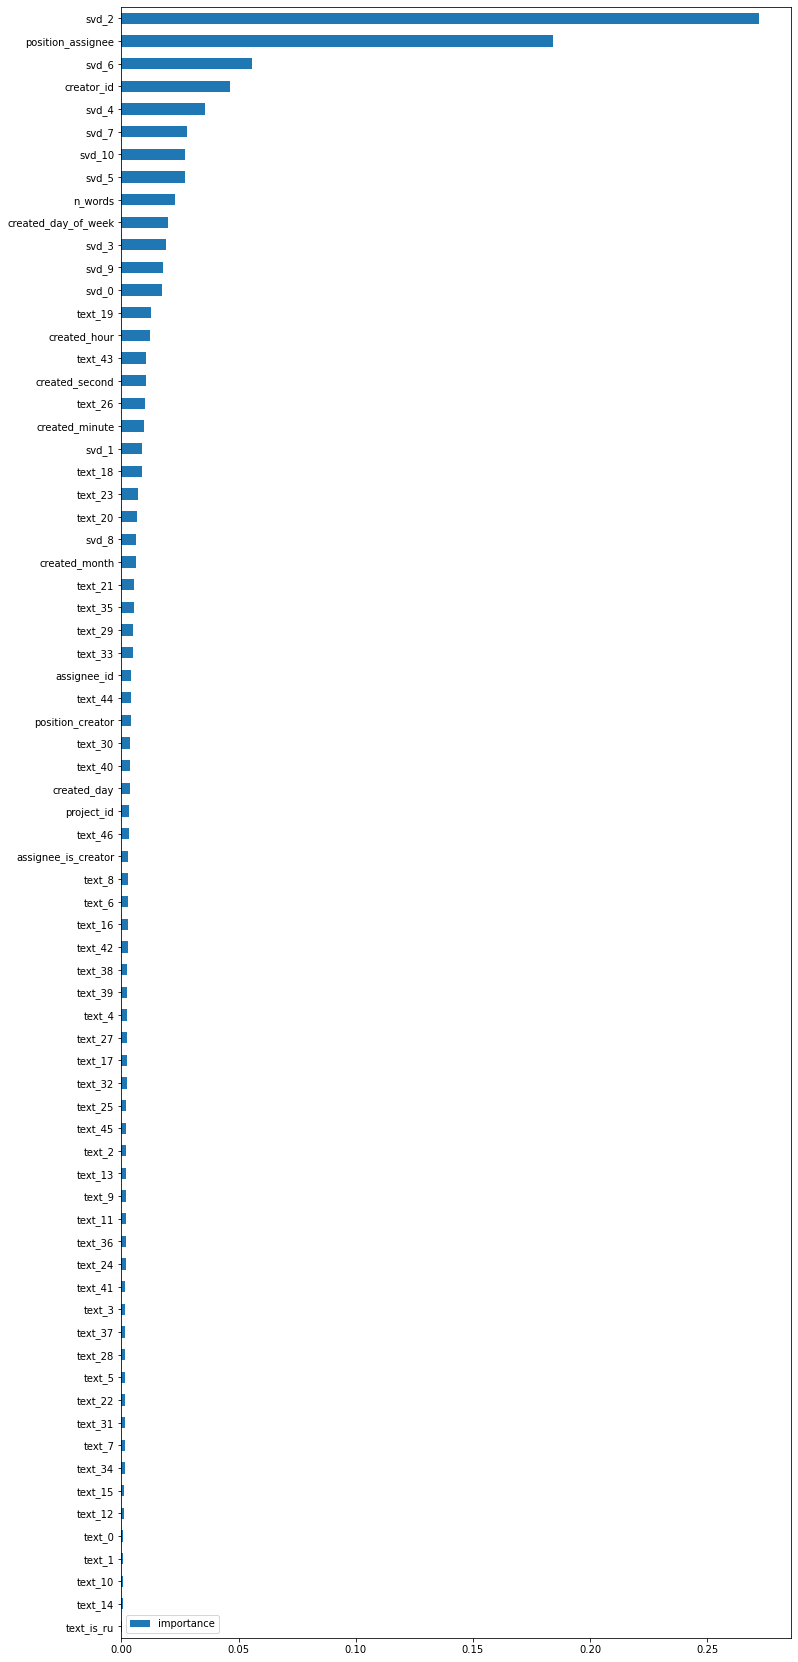

In [95]:
imp = pd.DataFrame(model.feature_importances_, X_val_temp.columns, columns=['importance']).sort_values('importance')
imp.plot(kind='barh', figsize=(12, 30))

# sample_solution

In [217]:
sample_solution = pd.read_csv('sample_solution.csv', index_col='id')
sample_solution['overall_worklogs'] = model.predict(X_test_temp)
sample_solution.to_csv('sample_solution_sas.csv')

In [218]:
sample_solution

,overall_worklogs
id,
675975,42387.648438
675972,11159.436523
675965,11667.401367
675961,11614.451172
675955,35987.308594
...,...
702545,5788.831055
702528,8370.842773
702499,15532.326172
